<a href="https://colab.research.google.com/github/guiguilhermegui/TF/blob/main/modelo_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Checkout www.pygimli.org for more examples
#!pip install pygimli tetgen


# Hydrogeophysical modelling

Coupled hydrogeophysical modelling example. This essentially represents the
forward modelling step of the example presented in section 3.2 of the [pyGIMLi
paper](http://www.sciencedirect.com/science/article/pii/S0098300417300584/pdfft?md5=44253eaacd5490e3fb32210671672496&pid=1-s2.0-S0098300417300584-main.pdf).


Create geometry definition for the modelling domain



In [2]:
# OK
# imports

import numpy as np
import matplotlib.pyplot as plt
import pygimli as pg
import pygimli.meshtools as mt
import pygimli.physics.ert as ert
import pygimli.physics.petro as petro
from pygimli.physics import ERTManager

In [3]:
# Parametros dos furos
bores = [-20, -15, -10, -5, 0, 5, 10, 15]                       # Posição central dos furos
prof_poco=-0.9
altura_poco= 0
raio_poco=0.35   #precisa ser decimal Ex:"3.00001"

# OK Posicoes relativas do furo
esq = '.' + f'{raio_poco:.2f}'.split('.')[1]
dir = '.' + f'{1 - raio_poco:.2f}'.split('.')[1]
#print(f'raio_poco={raio_poco:.2f} esq={esq} dir={dir}')

# limites world sandbox
box_esq=-30
box_dir=30
box_top=0.01
box_bottom=-20

# parâmetros de malha
mesh_area=0.4               # area da mesh em metros^2
mesh_quality=30             # qualidade da mesh evitar valores acima de 33 por questões de performance

# Atribute hydraulic conductivity in m/s to each region (interfaces/layers) of the model
K_poco = 1e4
K_mundo = 1e-9

#markers
kMap = [[1, K_mundo],  [9, K_poco]] #[0, 3e-1],    #Use [[RegionMarker, ConductivityValue], ...]

# Definições de variáveis e funções
#h0 = altura_poco            # Altura inicial da água no poço
#h2o = h0 - prof_poco        # Altura da linha da água inicial no poço
#h2o2=0
#y=0.0001
#y = 0.1  # Defina a variação na linha vertical da fronteira
# Defina os parâmetros iniciais hidráulicos
#taxa_de_infiltracao = 0.005 # Taxa de infiltração em m/s
#num_iteracoes = 20          # Número de iterações dt para simulação
#dt = 1                      # Intervalo de tempo em segundos

# Dirichlet conditions for hydraulic potential

# Definir valores de fronteira pro potencial hidráulico 
# fronteiras 1top, 2lat,3_fundo,4latmundo,-2basemundo,-1topomundo
basemundo_2 = 0.0
topo7 = 0.9
#laterais8 = h202             # Defina a altura da água nas laterais
#fundo9 = 0.9   #h20           # Defina a altura da água no poço
pBound = {"Dirichlet": {-2: basemundo_2, 1: topo7}} #{marker: value, ...} #Dirichlet, Neumann, Robin
#pBound = pBound.append("Neumann":{2: laterais8, 3:fundo9})


# Parâmetros do meio poroso para adveccao-dispersao
phi = 0.3                    # Porosidade meio
#D = 0.01                    # Coeficiente de dispersão m^2/s


# Fluid                      # Condutividade elétrica da água em S/m
# Create conductivity of fluid for salt concentration :math:`c` sigmaFluid = c[timesERT] * sigma_bx + sigma_a
sigma_a = -0.00031
sigma_bx = 0.19330           # Condutividade = A+bx   

TracerCon = 13.27            # Concentração em g/l
res_water = 10000            # Resistividade da água em Ohm.m

cementation_exponent = 1.1,  # Exponente de cimentação para a resistividade do solo



# Simulação
TimeSimu_days = 1            # Tempo de simulação em dias  
n=30                           # Tempo em minutos
TimeSimu_slice = n*60        # Número de fatias para a simulação em time steps

number_of_timesERT = 10      # Número de vezes que a simulação de ERT é executada

#background resistivity model parameters
Layer1=-8                    # Profundidade da camada 1
RLayer1=150                  # Resistividade da camada 1
Layer2=(-2)                  # Profundidade da camada 2
RLayer2=500                  # Resistividade da camada 2


# OK ERT parameters
ERT_dist= 600                # Distância total dos eletrodos em metros
ERT_elecs = 60               # Quantidade de eletrodos
ERT_spac = 10                # Espaçamento entre os eletrodos em metros
ERT_Array = 'dd'
elecs = np.linspace(-ERT_dist/2, ERT_dist/2, ERT_elecs)


In [4]:
# OK
# Create a 2D world box
world = mt.createWorld(start=[box_esq, box_top], end=[box_dir, box_bottom], WorldMarker=True,) #layers=[-2,-8]) 

# Create boreholes
poco = []
for pos in bores:
    poco.append(mt.createRectangle(start=[pos - raio_poco, altura_poco], end=[pos + raio_poco,prof_poco], marker=9))
boreholes = poco[0]
for borehole in poco[1:]:
    boreholes = boreholes + borehole


# Create geometry of model
geom = world + boreholes
mesh = mt.createMesh(geom, quality=mesh_quality, area=mesh_area, smooth=[1, 10])
#pg.show(mesh)

coord = []
# Create figure
#ax, _ = pg.show(geom, markers=False, orientation='vertical', figsize=(15, 8), showNodes=True, showMesh=True)
# Print nodes
for i, n in enumerate(geom.nodes()):
#    ax.text(n.x(), n.y(), str(i), color='blue', size=10)
    coord.append([i, n.x(), n.y()])
# Print 4 lists of nodes per line, very useful for rectangles
#for i in range(0, len(coord), 4):
#    print('coord' + str(coord[i:i+4]))


In [5]:
# OK
# Calculo doido de coordenadas dos nós
leftneg_boundaries = [boundary.id() for boundary in geom.boundaries() if (boundary.center()[0] < 0 and str(boundary.center()[0]).endswith(esq))]
leftpos_boundaries = [boundary.id() for boundary in geom.boundaries() if (boundary.center()[0] > 0 and str(boundary.center()[0]).endswith(dir))]
rightpos_boundaries = [boundary.id() for boundary in geom.boundaries() if (boundary.center()[0] > 0 and str(boundary.center()[0]).endswith(esq))]
rightneg_boundaries = [boundary.id() for boundary in geom.boundaries() if (boundary.center()[0] < 0 and str(boundary.center()[0]).endswith(dir))]
left_boundaries = leftneg_boundaries + leftpos_boundaries
right_boundaries = rightneg_boundaries + rightpos_boundaries

top_boundaries = [boundary.id() for boundary in geom.boundaries() if boundary.center()[1] == altura_poco]
bottom_boundaries = [boundary.id() for boundary in geom.boundaries() if boundary.center()[1] ==prof_poco]
world_boundaries = [boundary.id() for boundary in geom.boundaries() if boundary.id() not in top_boundaries + bottom_boundaries + left_boundaries + right_boundaries]

#print('left_boundaries: ' + str(left_boundaries))
#print('bottom_boundaries: ' + str(bottom_boundaries))
#print('right_boundaries: ' + str(right_boundaries))
#print('top_boundaries: ' + str(top_boundaries))
#print('world_boundaries: ' + str(world_boundaries))


(<Axes: xlabel='$x$ in m', ylabel='Depth in m'>, None)

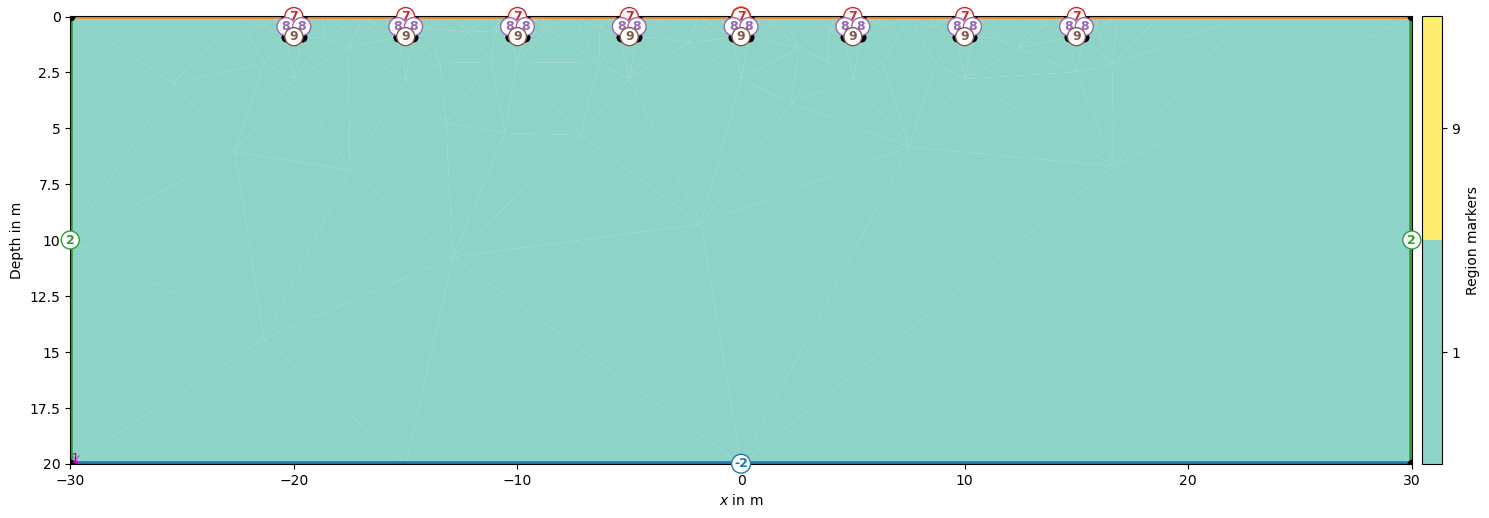

In [6]:
# OK
# Atribuição da numeracao das fronteiras boreholes
def pos(count):
    return pg.Pos(coord[count][1], coord[count][2])
for a in range(len(bottom_boundaries)):
    geom.createEdge(geom.node(bottom_boundaries[a]), geom.node(right_boundaries[a]), marker=9)

for a in range(len(right_boundaries)):
    geom.createEdge(geom.node(top_boundaries[a]), geom.node(right_boundaries[a]), marker=8)

for a in range(len(left_boundaries)):
    geom.createEdge(geom.node(bottom_boundaries[a]), geom.node(left_boundaries[a]), marker=8)
for a in range(len(top_boundaries)):
    geom.createEdge(geom.node(left_boundaries[a]), geom.node(top_boundaries[a]), marker=7)


# Fronteiras world
geom.createEdge(geom.node(0), geom.node(1), marker= 2)#esq
geom.createEdge(geom.node(1), geom.node(2), marker=-2)#fundo
geom.createEdge(geom.node(2), geom.node(3), marker= 2)#dir
geom.createEdge(geom.node(3), geom.node(0), marker= -1)#topo mundo

pg.show(geom, label='Boundary marker', markers=True, showMesh=True, figsize=(15, 8), orientation='vertical' )

Fluid flow in a porous medium of slow non-viscous and non-frictional hydraulic
movement is governed by Darcy's Law according to:

\begin{align}K^{-1}\mathbf{v} + \nabla p & = 0 \\
   \nabla \cdot \mathbf{v} & = 0\\
   \text{leading}\,\,\text{to}\,\,
   \nabla\cdot(K \nabla p) & = 0 \quad \text{on} \quad\Omega\end{align}

We begin by defining isotropic values of hydraulic conductivity $K$ and
mapping these to each mesh cell:



In [7]:
""" PANICO """


# Map conductivity value per region to each cell in the given mesh
K = pg.solver.parseMapToCellArray(kMap, mesh)

#pg.show(mesh, rhoa=K, label='Hydraulic conductivity $K$ in m/s', cMin=1e-10, cMax=1e12, logScale=True, grid=True)

The problem further boundary conditions of the hydraulic potential. We use
$p=p_0=0.75$ m on the left and $p=0$ on the right boundary of the modelling
domain, equaling a hydraulic gradient of 1.75%.



\begin{split}c \frac{\partial u}{\partial t} & = \nabla\cdot(a \nabla u)
+ b u + f(\mathbf{r},t)~~|~~\Omega_{\text{Mesh}}\\
u & = h~~|~~\Gamma_{\text{Dirichlet}}\\
a\frac{\partial u}{\partial \mathbf{n}} & =
g~~|~~\Gamma_{\text{Neumann}}\\
\alpha u + \beta\frac{\partial u}{\partial \mathbf{n}} & =
\gamma~~|~~\Gamma_{\text{Robin}}\\
\frac{\partial u}{\partial \mathbf{n}} & =
\alpha(u_0-u)~~|~~\Gamma_{\text{Robin}}\end{split}

https://www.pygimli.org/pygimliapi/_generated/pygimli.solver.html#pygimli.solver.solveFiniteElements

In [8]:
""" PANICO """
#parcial = 10
#mostrar_parcial = False
#mostrar_cada_iteracao = False

#p = np.random.rand(mesh.cellCount())                   # Inicialize com potencial hidráulico aleatorio


# Resolver o modelo de potencial hidráulico
p = pg.solver.solveFiniteElements(mesh, a=K, bc=pBound, verbose=True)


#Loop para simular o preenchimento e esvaziamento do poço 
# 
# 
# ## já vai ser feito lá embaixo em FiniteVolume  
#   ainda vai precisar simular esvaziamento pras fronteiras laterais do poço
# 
# Calcular a nova altura do poço com base na taxa de esvaziamento
#h2o = h0 - prof_poco - taxa_de_infiltracao * dt
# Garantir que a altura do poço não fique negativa


#    if mostrar_cada_iteracao == True:
#        pg.show(mesh, data=p, label='Potencial Hidráulico após iteração {}'.format(t))
#    if mostrar_parcial == True:
#        if t % parcial == 0:
#            pg.show(mesh, data=p, label='Potencial Hidráulico após iteração {}'.format(t))




# (Opcional) Adicionar uma pausa para visualização
# plt.pause(0.1)  # Se você estiver usando matplotlib para visualização
#pg.show(mesh, rhoa=p, label='Potencial Hidráulico após iteração {}'.format(t))
#print(pBound)
#print(h2o)




Mesh:  Mesh: Nodes: 4357 Cells: 8084 Boundaries: 12440
Assembling time:  0.0459599
Solving time:  0.0612422


We can now call the finite element solver with the generated mesh, hydraulic
conductivity and the boundary condition. The sought hydraulic velocity
distribution can then be calculated as the gradient field of
$\mathbf{v}=-\nabla p$ and visualized using the generic `pg.show()` function.



In [9]:
# OK
# Calculate statistics
mean_p = np.mean(p)
std_p = np.std(p)
min_p = np.min(p)
max_p = np.max(p)

print(f"Mean: {mean_p}, Std: {std_p}, Min: {min_p}, Max: {max_p}")

Mean: 0.5661188114947397, Std: 0.35026590400488444, Min: 0.0, Max: 0.9000021484266773


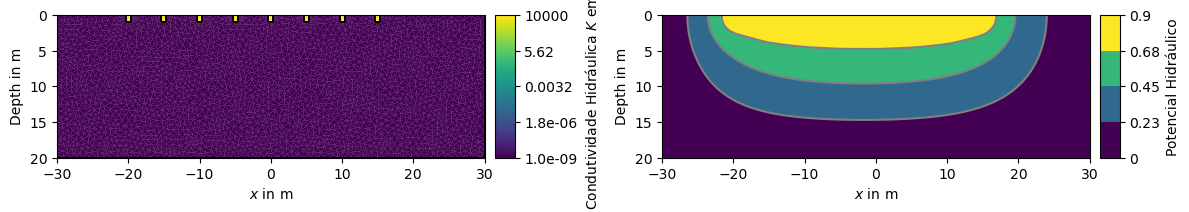

In [10]:
# OK
# Atualizar a visualização ou armazenar resultados
fig, axs = plt.subplots(1,2,figsize=(12, 12))
pg.show(mesh, rhoa=K, label='Condutividade Hidráulica $K$ em m/s', logScale=True, ax=axs[0],orientation='vertical')
pg.show(mesh, rhoa=p, label='Potencial Hidráulico', cMin=min_p, cMax=max_p, ax=axs[1],orientation='vertical')
plt.show()

Mean Velocity: -1.8275045307759135e-11, Std: 3.9769328361813146e-10, Min: -3.907985046680551e-09, Max: 4.227729277772596e-09


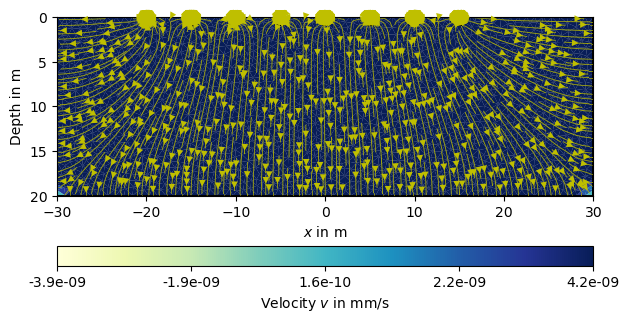

In [11]:
""" Entendido """
# Solve velocity as gradient of hydraulic potential
vel = -pg.solver.grad(mesh, p) * np.asarray([K, K, K]).T #4D

""" Entendido """
# Calculate statistics for the new range
mean_vel = np.mean(vel)
std_vel = np.std(vel)
min_vel = np.min(vel)
max_vel = np.max(vel)

print(f"Mean Velocity: {mean_vel}, Std: {std_vel}, Min: {min_vel}, Max: {max_vel}")

ax, _ = pg.show(mesh, rhoa=pg.abs(vel) * 1000, cMin=min_vel, cMax=max_vel,
                label='Velocity $v$ in mm/s', cMap='YlGnBu', hold=True)
ax, _ = pg.show(mesh, rhoa=vel, ax=ax, color='y', linewidth=0.6, dropTol=1e-12,
                hold=True)

In [12]:
#OK
# Initialize the source vector of injections
load_vector = pg.Vector(mesh.cellCount(), 0.0)

# Fill injection source vector for a fixed injection position
for pos in bores:
    sourceCell = mesh.findCell([pos, prof_poco])
    if sourceCell:
        load_vector[sourceCell.id()] += TracerCon / sourceCell.size()  # g/(l s)

\begin{split}\frac{\partial u}{\partial t} + \mathbf{v}\cdot\nabla u & = \nabla\cdot(a \nabla u) + b u + f(\mathbf{r},t)\\
u(\mathbf{r}, t) & = u_B  \quad\mathbf{r}\in\Gamma_{\text{Dirichlet}}\\
\frac{\partial u(\mathbf{r}, t)}{\partial \mathbf{n}} & = u_{\partial \text{B}}  \quad\mathbf{r}\in\Gamma_{\text{Neumann}}\\
u(\mathbf{r}, t=0) & = u_0 \quad\text{with} \quad\mathbf{r}\in\Omega\end{split}

Parameters
:
mesh (GIMLI::Mesh) – Mesh represents spatial discretization of the calculation domain

a (value | array | callable(cell, userData)) – Stiffness weighting per cell values.

b (value | array | callable(cell, userData)) – Scale for mass values b

f (iterable(cell)) – Load vector

fn (iterable(cell)) – TODO What is fn

vel (ndarray (N,dim) | RMatrix(N,dim)) – Velocity field 
v(r,t=const)={[vi]j,}
 with 
i=[1…3]
 for the mesh dimension and 
j=[0…N−1]
 with N either the amount of cells, nodes, or boundaries. Velocities per boundary are preferred and will be interpolated on demand.

u0 (value | array | callable(cell, userData)) – Starting field

times (iterable) – Time steps to calculate for.

Workspace (ws) –

This can be an empty class that will used as an Workspace to store and cache data.

If ws is given: The system matrix is taken from ws or calculated once and stored in ws for further usage.

The system matrix is cached in this Workspace as ws.S The LinearSolver with the factorized matrix is cached in this Workspace as ws.solver The rhs vector is only stored in this Workspace as ws.rhs

scheme (str [CDS]) – Finite volume scheme: pygimli.solver.diffusionConvectionKernel

**kwargs –

bc : Boundary Conditions dictionary, see pg.solver

In [13]:
""" PANICO """
# Choose n slices  time steps for TimeSimulation days to seconds
t = pg.utils.grange(0, TimeSimu_days * 24 * 3600, n=TimeSimu_slice)

# Create dispersitivity, depending on the absolute velocity
dispersion = pg.abs(vel) * 1e2  # thik it is to transform from mm/s to m/s ?

# Solve for injection time, but we need velocities on cell nodes
veln = mt.cellDataToNodeData(mesh, vel)
c1 = pg.solver.solveFiniteVolume(mesh, a=dispersion, f=load_vector, vel=veln, times=t,
                                 scheme='PS', verbose=0)

# Solve without injection starting with last result
c2 = pg.solver.solveFiniteVolume(mesh, a=dispersion, f=0, vel=veln, u0=c1[-1],
                                 times=t, scheme='PS', verbose=0)
# Stack results together
c = np.vstack((c1, c2))

# We can now visualize the result:
# Calculate statistics
mean_c = np.mean(c)
std_c = np.std(c)
min_c = np.min(c)
max_c = np.max(c)
min_c_calc = 0 #mean_c - 1 * std_c
max_c_calc = mean_c + 1 * std_c
print(f"Mean: {mean_c}, Std: {std_c}, Min: {min_c}, Max: {max_c}")



c:\Users\gui\.conda\envs\pg\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve


Mean: 11855.004537316812, Std: 441960.3126270246, Min: 0.0, Max: 32673089.222824905


min() arg is an empty sequence
Traceback (most recent call last):
  File "c:\Users\gui\.conda\envs\pg\lib\site-packages\pygimli\viewer\showmesh.py", line 426, in showMesh
    gci, validData = _drawField(ax, mesh, data, kwargs)
  File "c:\Users\gui\.conda\envs\pg\lib\site-packages\pygimli\viewer\showmesh.py", line 391, in _drawField
    gci = drawModel(ax, mesh, data, **kwargs)
  File "c:\Users\gui\.conda\envs\pg\lib\site-packages\pygimli\viewer\mpl\meshview.py", line 385, in drawModel
    pg.viewer.mpl.setMappableData(gci, viewdata,
  File "c:\Users\gui\.conda\envs\pg\lib\site-packages\pygimli\viewer\mpl\colorbar.py", line 512, in setMappableData
    cMin = min(data[data > 0.0])
ValueError: min() arg is an empty sequence


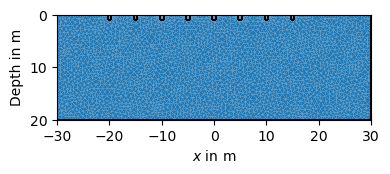

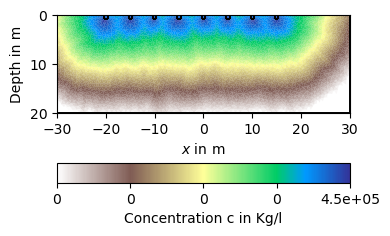

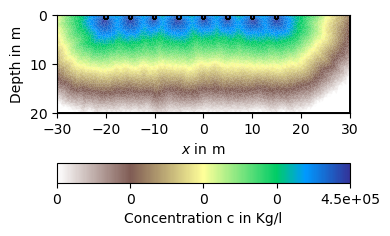

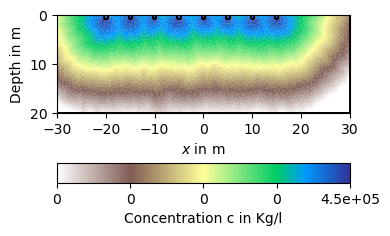

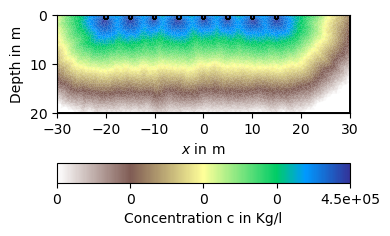

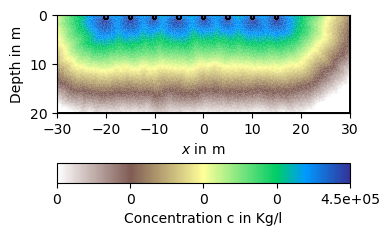

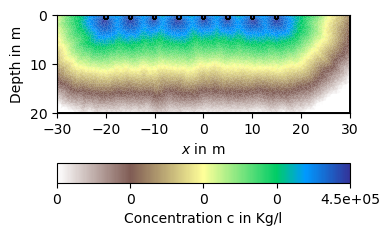

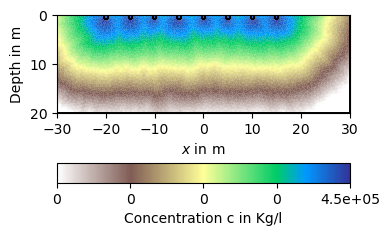

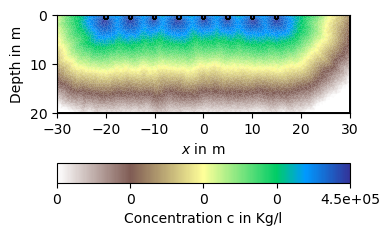

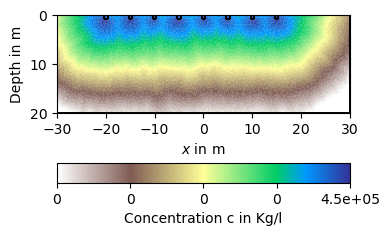

In [14]:
# OK


# Visualize the result
for ci in c[0:10][::1]:

    pg.show(mesh, data=ci, cMin=min_c_calc, cMax=max_c_calc, cMap="terrain_r", logScale=True,
            label="Concentration c in Kg/l", figsize=(4, 8), orientation='horizontal')
    



In [15]:
print(min_c_calc)
print(min_c)

0
0.0


Warning! DataSchemeBase::create has unhandled arguments
{'spacing': 10}


(<Axes: xlabel='$x$ in m', ylabel='Depth in m'>, None)

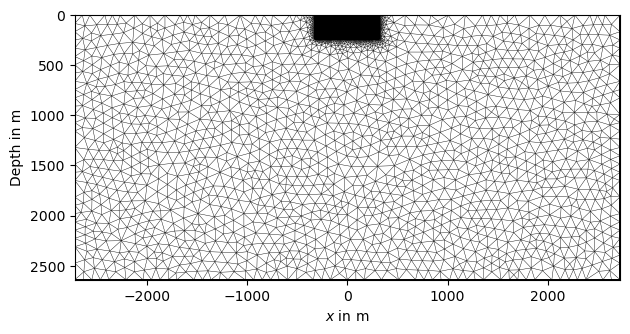

In [16]:
# OK
# Create ERT measurement scheme
ertScheme = ert.createData(elecs=elecs, schemeName=ERT_Array, spacing=ERT_spac)

""" PANICO """
meshERT = mt.createParaMesh(ertScheme, quality=mesh_quality, paraMaxCellSize=10, nLayers=1,
boundaryMaxCellSize=7500, smooth=[1, 2])

pg.show(meshERT)

Lei de Archie

$$R_f = R_r (1 - S_w)^m$$
Rf is the fluid resistivity

Rr is the rock resistivity

Sf is the fluid saturation

m is the cementation exponent

In [17]:


timesERT = pg.IVector(np.floor(np.linspace(0, len(c) - 1, number_of_timesERT)).astype(int)) # Select 10 time frame to simulate ERT data

# Create conductivity of fluid for salt concentration :math:`c`
sigmaFluid = c[timesERT] * sigma_bx + sigma_a
c = np.array(c)  # Ensure c is a numpy array

# Calculate bulk resistivity based on Archie's Law, by ratio of res water and sigmaFluid
resBulk = petro.resistivityArchie(rFluid = res_water / sigmaFluid, porosity = phi, m=cementation_exponent, mesh=mesh, meshI=meshERT, fill=1)


# apply background resistivity model
rho0 = np.zeros(meshERT.cellCount()) + 1000.

for cell in meshERT.cells():
    if cell.center()[1] < Layer1:
        rho0[cell.id()] = RLayer1
    elif cell.center()[1] < Layer2:
        rho0[cell.id()] = RLayer2
resis = pg.Matrix(resBulk)
for i, rbI in enumerate(resBulk):
    resis[i] = 1. / ((1. / rbI) + 1. / rho0)



12/01/25 - 21:37:42 - pyGIMLi - WARNING - parseMapToCellArray: cannot find marker 1.1 within mesh.


In [ ]:
ERT = ERTManager(verbose=False)

# Run simulation for the apparent resistivities
rhoa = ERT.simulate(meshERT, res=resis, scheme=ertScheme, 
                    returnArray=True, verbose=False, noiseLevel=1e-2, noiseAbs=1e-6,)
print('Simulated rhoa', rhoa, np.max(rhoa))

# Its possible that there are some negative data values due to noise and
# huge geometric factors. So we need to remove them
rhoa.markInvalid(rhoa('rhoa') < 0)
print('Filtered rhoa', rhoa('rhoa'), max(rhoa('rhoa')))
rhoa.removeInvalid()

# Optional: save the data for further use
#data.save('simple.dat')

# Calculate statistics for rhoa
#Min_calcERT=mean_rhoa-2*std_rhoa
#Max_calcERT=mean_rhoa+2*std_rhoa 
#cMin=1e-4
#cMax=1

# Plot the first 4 timesteps normalized by the first timestep
# Print the statistics
for i in range(len(rhoa)):

    # Create a copy of the scheme for each visualization
    tempScheme = ertScheme.copy()
    tempScheme.set('rhoa', rhoa[i])
    
    mean_rhoa = np.nanmean(rhoa[i])
    std_rhoa = np.nanstd(rhoa[i])
    min_rhoa = np.nanmin(rhoa[i])
    max_rhoa = np.nanmax(rhoa[i])
    Min_calcERT=min_rhoa
    Max_calcERT=max_rhoa
    print(f"Timestep {i+1}:")
    print(f"Mean: {mean_rhoa}, Std: {std_rhoa}, Min: {min_rhoa}, Max: {max_rhoa}, Min_calcERT: {Min_calcERT}, Max_calcERT: {Max_calcERT},")
    print()

    # Show the data and get the Axes object
    ax, _ = ERT.showData(tempScheme, vals=rhoa[i]/rhoa[0],cMin=Min_calcERT,cMax=Max_calcERT)

    # Set the Y-axis limit to cut off below DD12
    dd12_y_limit = 12  # Replace with the actual Y-coordinate for DD12
    ax.set_ylim(dd12_y_limit, ax.get_ylim()[1])  # Set the lower limit to DD12

    # Optionally, you can add titles or labels
    ax.set_title(f'Timestep {i+1} normalized by Timestep 1')
    ax.set_xlabel('X-axis label')  # Replace with your actual label
    ax.set_ylabel('Y-axis label')  # Replace with your actual label

    # Show the plot
    plt.show()

RuntimeError: ./core/src/datacontainer.cpp:687		void GIMLI::DataContainer::set(const std::string&, const GIMLI::RVector&)  wrong data size: 1653 10

In [19]:
#Backup
""" ERT = ERTManager(verbose=False)
# Run  simulation for  the apparent resistivities
rhoa = ERT.simulate(meshERT, res=resis, scheme=ertScheme,
                    returnArray=True, verbose=False)

for i in range(4):
    ERT.showData(ertScheme, vals=rhoa[i]/rhoa[0], logScale=False, label='Apparent resistivity',) """

" ERT = ERTManager(verbose=False)\n# Run  simulation for  the apparent resistivities\nrhoa = ERT.simulate(meshERT, res=resis, scheme=ertScheme,\n                    returnArray=True, verbose=False)\n\nfor i in range(4):\n    ERT.showData(ertScheme, vals=rhoa[i]/rhoa[0], logScale=False, label='Apparent resistivity',) "